In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from numpy import array, inf, load
import numpy as np
from quantecon import cartesian
import glob


SimplexResult = namedtuple(
    'SimplexResult', ['x', 'lambd', 'fun', 'success', 'status', 'num_iter']
)


filename_res = 'results.csv'
filename_runtimes = 'exec_time.csv'

df_res = pd.read_csv(filename_res, index_col=0)
df_runtime = pd.read_csv(filename_runtimes, index_col=0)

## Results analysis

In [67]:
df_res_tuple = df_res.applymap(lambda x: eval(x))

In [72]:
df_res_success = df_res_tuple.applymap(lambda x: int(x.success))

Text(0.5, 0, 'Problem index')

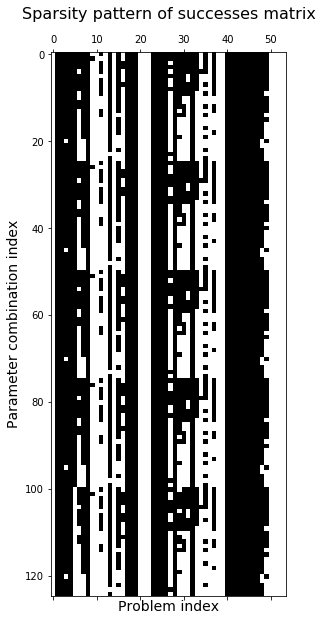

In [147]:
plt.figure(figsize=(10, 10))
plt.spy(df_res_success.values, aspect=None);
plt.title('Sparsity pattern of successes matrix', fontsize=16);
plt.ylabel('Parameter combination index', fontsize=14)
plt.xlabel('Problem index', fontsize=14)

Note: Parameter combinations are generated using: 

```python
fea_tol_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
tol_piv_list = [1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
tol_ratio_diff_list = [1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

param_set = cartesian((fea_tol_list, tol_piv_list, tol_ratio_diff_list))
```

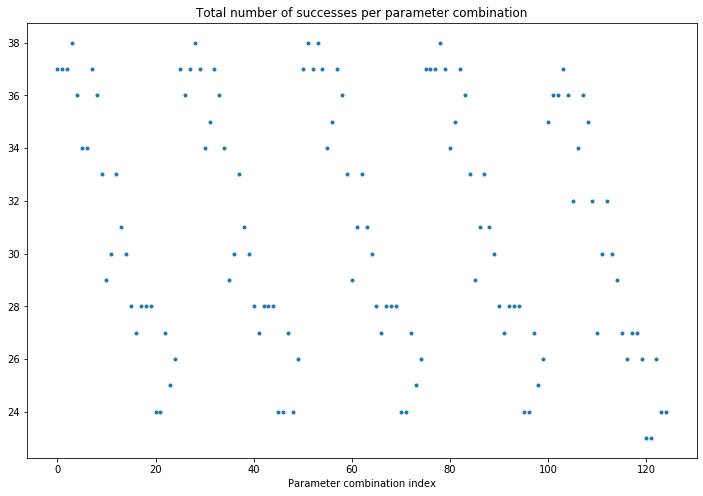

In [170]:
plt.figure(figsize=(12, 8))
plt.plot(df_res_success.sum(axis=1), 'o', markersize=3.);
plt.xlabel('Parameter combination index');
plt.title('Total number of successes per parameter combination');

In [207]:
# Set of maximizers
argmax_set = df_res_success[df_res_success.sum(axis=1) == df_res_success.sum(axis=1).max()].index
argmax_set

Int64Index([3, 28, 51, 53, 78], dtype='int64')

## Observations

- There are multiple maximimzers.
- Some parameter combinations seem to perform much better than others

In [195]:
df_res_fun = df_res_tuple.applymap(lambda x: x.fun)

In [196]:
# path
data_dir = './linprog_benchmark_files/'

# full_problem_list
problem_list = glob.glob(data_dir + '*.npz')
problem_list.sort()
remove_list = ['80BAU3B', 'BORE3D', 'CAPRI', 'CYCLE', 'CZPROB', 'D6CUBE',
               'DFL001', 'ETAMACRO', 'FINNIS', 'FIT1D', 'FIT1P', 'FIT2D',
               'FIT2P', 'GANGES', 'GFRD-PNC', 'GREENBEA', 'GREENBEB',
               'GROW15', 'GROW22', 'GROW7', 'KB2', 'MAROS', 'MODSZK1',
               'PEROLD', 'PILOT', 'PILOT-JA', 'PILOT-WE', 'PILOT4',
               'PILOT87', 'PILOTNOV', 'RECIPE', 'SHELL', 'SIERRA',
               'STAIR', 'STANDATA', 'STANDMPS', 'TUFF', 'VTP-BASE'
               ]
for name in remove_list:
    problem_list.remove(data_dir + name + '.npz')

    
problems = [load(problem) for problem in problem_list]
funs = array([-problem['obj'] for problem in problems])

In [197]:
TOL = 1e-1

abs_diff = np.abs(df_res_fun - funs)
rel_diff =  np.abs(df_res_fun / funs) - 1

In [198]:
df_res_success_alt = (abs_diff < TOL) | (rel_diff < TOL)

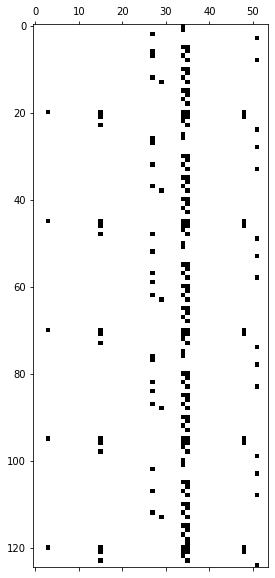

In [199]:
plt.figure(figsize=(10, 10))
plt.spy(np.abs(df_res_success - df_res_success_alt))

Text(0.5, 1.0, 'Total number of successes per parameter combination')

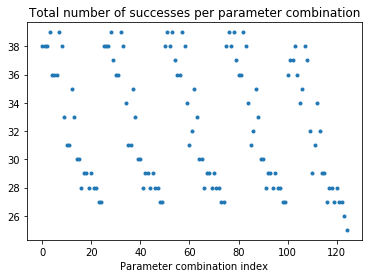

In [200]:
plt.plot(df_res_success_alt.sum(axis=1), 'o', markersize=3.);
plt.xlabel('Parameter combination index');
plt.title('Total number of successes per parameter combination')

In [206]:
# Set of maximizers
argmax_set_alt = df_res_success[df_res_success_alt.sum(axis=1) == df_res_success_alt.sum(axis=1).max()].index
argmax_set_alt

Int64Index([3, 7, 28, 32, 51, 53, 57, 76, 78, 82], dtype='int64')

In [212]:
# Check if argmax_set is a subset of argmax_set_alt
np.all([val in argmax_set_alt for val in argmax_set])

True

## Runtime Analysis

In [213]:
# Average runtime across parameters in seconds
df_runtime.mean(axis=0)

0       3.253722
1       0.000648
2       0.000279
3       0.012628
4       0.006856
5       0.009445
6       0.061489
7       0.002336
8       0.000814
9       0.857911
10     31.181053
11      0.006625
12     18.223627
13      0.285693
14     35.673586
15      0.016071
16      0.105491
17      0.018121
18      0.002398
19     56.941517
20    104.289606
21    487.451009
22      6.282606
23      0.001123
24      0.006736
25      0.000345
26      0.000357
27      0.099564
28      0.002191
29      0.044720
30      0.358154
31      0.857989
32      0.009040
33      0.155572
34      0.006681
35      0.028722
36      0.085894
37      0.020844
38      2.191749
39      0.604235
40      0.003860
41      0.001113
42      0.011211
43      0.006767
44      0.045263
45      0.026259
46      0.109595
47      0.056366
48      0.001940
49     12.637347
50    347.225003
51     30.743184
52      0.291943
53      2.682854
dtype: float64

In [214]:
# Runtime standard deviation across parameters in seconds
df_runtime.std(axis=0)

0       5.367004
1       0.000160
2       0.000134
3       0.000924
4       0.000296
5       0.000922
6       0.121339
7       0.000698
8       0.000087
9       1.609423
10     29.347564
11      0.005530
12     33.606941
13      0.053591
14     11.505233
15      0.004778
16      0.085604
17      0.000571
18      0.000120
19      0.216126
20    110.784449
21    506.702707
22      7.807428
23      0.000084
24      0.000556
25      0.000072
26      0.000072
27      0.045819
28      0.000134
29      0.116320
30      0.899254
31      0.866624
32      0.000312
33      0.364751
34      0.012946
35      0.016250
36      0.199378
37      0.013293
38      7.217489
39      1.368517
40      0.000192
41      0.000093
42      0.000598
43      0.000443
44      0.002395
45      0.001270
46      0.003774
47      0.001499
48      0.000138
49     10.791135
50     33.841769
51     23.302447
52      0.569074
53     11.053524
dtype: float64

## Observations

- Problem 20 and 21 have large standard deviations in terms of runtime across parameter combinations
- Problem 20, 21 and 50 take a long time to solve on average

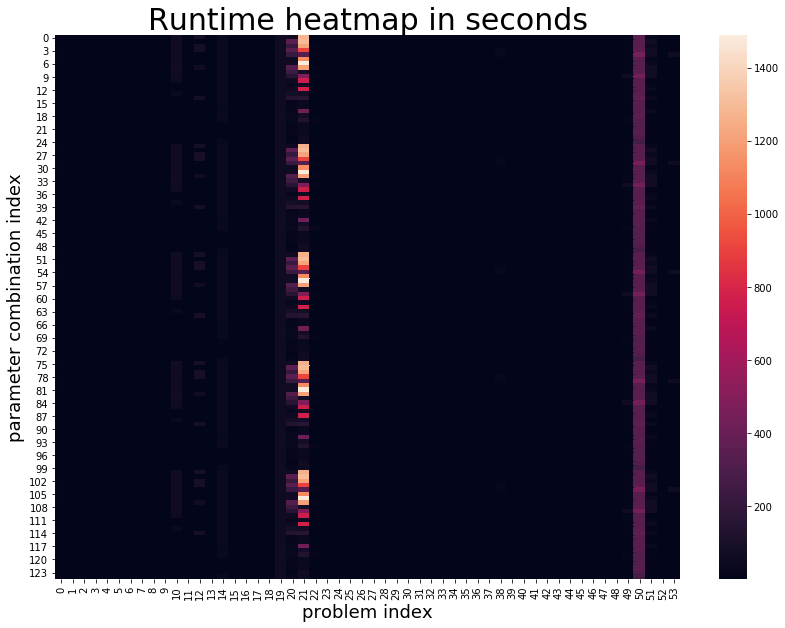

In [215]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_runtime)
plt.title('Runtime heatmap in seconds', fontsize=30)
plt.xlabel('problem index', fontsize=18);
plt.ylabel('parameter combination index', fontsize=18);

In [229]:
df_runtime.loc[argmax_set_alt].mean(axis=1)

3     36.967260
7     40.652987
28    37.019828
32    40.748995
51    41.829716
53    36.640861
57    40.788475
76    41.832018
78    36.945070
82    40.777253
dtype: float64

In [231]:
fea_tol_list = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
tol_piv_list = [1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
tol_ratio_diff_list = [1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

param_set = cartesian((fea_tol_list, tol_piv_list, tol_ratio_diff_list))

In [232]:
# Minimize average runtime conditional on maximizing total number of success
param_set[df_runtime.loc[argmax_set_alt].mean(axis=1).idxmin()]

array([1.e-06, 1.e-08, 1.e-14])